In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [112]:
df = pd.read_csv('/Users/anikatripathi/Downloads/data/student/student-mat.csv', sep=';')
print(df.head())
print(df.shape)
# had to seperate by ; instead of the default , bc that is standard practice is european countries
columns_table = pd.DataFrame(df.columns, columns=['Column Names'])

print(columns_table)

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]
(395, 33)
   Column Names
0        school
1           sex
2           age
3       addres

In [114]:
# Data Cleaning and preprocessing

# Drop G1 and G2
df = df.drop(columns=['G1', 'G2'])

# Binary Encoding 
binary_columns = ['sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup',
                  'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

for col in binary_columns:
    df[col] = df[col].map({'yes': 1, 'no': 0, 'F': 0, 'M': 1, 'U': 1, 'R': 0, 'LE3': 0, 'GT3': 1, 'T': 1, 'A': 0, 'True': 1, 'False': 0})

# One-Hot Encoding for categorical variables
df = pd.get_dummies(df, columns=['school', 'Mjob', 'Fjob', 'reason', 'guardian'], drop_first=True)

#encode the target as binary pass/fail
def pass_fail(g):
    if g >= 10:
        return 'pass'
    else:
        return 'fail'
#change pass/fail to 1/0
df['G3_pass_fail'] = df['G3'].apply(pass_fail)
df['G3_pass_fail'] = df['G3_pass_fail'].map({'pass': 1, 'fail': 0})
X = df.drop(columns=['G3_pass_fail']) 
y = df['G3_pass_fail']                

# Train-test split with 80-20 because we have a small data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=75)

print(df.head())

   sex  age  address  famsize  Pstatus  Medu  Fedu  traveltime  studytime  \
0    0   18        1        1        0     4     4           2          2   
1    0   17        1        1        1     1     1           1          2   
2    0   15        1        0        1     1     1           1          2   
3    0   15        1        1        1     4     2           1          3   
4    0   16        1        1        1     3     3           1          2   

   failures  ...  Fjob_health  Fjob_other  Fjob_services  Fjob_teacher  \
0         0  ...        False       False          False          True   
1         0  ...        False        True          False         False   
2         3  ...        False        True          False         False   
3         0  ...        False       False           True         False   
4         0  ...        False        True          False         False   

   reason_home  reason_other  reason_reputation  guardian_mother  \
0        False         F

In [116]:
#check number of rows to ensure preprocessing retains them
num_rows = len(df)
print("Number of rows:", num_rows)

Number of rows: 395


In [118]:
from sklearn.preprocessing import StandardScaler, Normalizer

# 1. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Normalizing (overwriting the same variable)
normalizer = Normalizer()
X_train_scaled = normalizer.fit_transform(X_train_scaled)
X_test_scaled = normalizer.transform(X_test_scaled)

In [120]:
print(y.value_counts())

G3_pass_fail
1    265
0    130
Name: count, dtype: int64


In [122]:
#Use SMOTE for class imbalances
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
smote = SMOTE(random_state=75)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

In [124]:

# Create the Vanilla model with default settings (n_neighbors=5)
knn = KNeighborsClassifier()
knn.fit(X_train_balanced, y_train_balanced)

KNeighborsClassifier()

In [126]:
# Make predictions
y_pred = knn.predict(X_test_scaled)

In [128]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6329113924050633


In [130]:
# calculate the F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

F1 Score: 0.6247472944440478


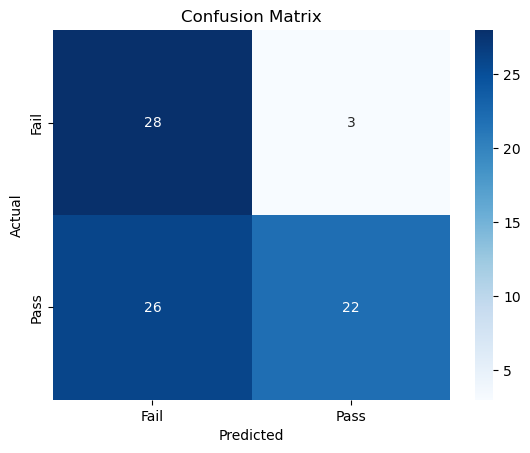

In [132]:
#Plot Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [134]:
#Making sure the 20% to test is correct
print("Total test samples:", len(y_test))

Total test samples: 79


In [136]:
#Trying to remove warnings, but ended up fixing code to avoid them
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.simplefilter('ignore')

In [138]:
#GridSearch for best hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 21)),  # Try k from 1 to 20
    'weights': ['uniform', 'distance'],  # Equal weight or distance-weighted
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Try different distance metrics
}

# Initialize KNN 
knn = KNeighborsClassifier()

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  
    n_jobs=-1  
)


grid_search.fit(X_train_scaled, y_train)

# Best model
best_knn = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


y_pred = best_knn.predict(X_test_scaled)
from sklearn.metrics import accuracy_score
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 16, 'weights': 'uniform'}
Best Cross-Validation Accuracy: 0.7722222222222221
Test Set Accuracy: 0.7721518987341772


In [139]:
#From GridSearch: 
#Best Parameters: {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'uniform'}
#Best Cross-Validation Accuracy: 0.7721230158730158
#Test Set Accuracy: 0.7468354430379747


In [140]:
#Fit and Train using best KNN hyperparameters from GridSearch
best_knn = KNeighborsClassifier(
    n_neighbors=8,
    weights='uniform',
    metric='euclidean')


best_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=8)

In [141]:
y_pred_grid = best_knn.predict(X_test_scaled)

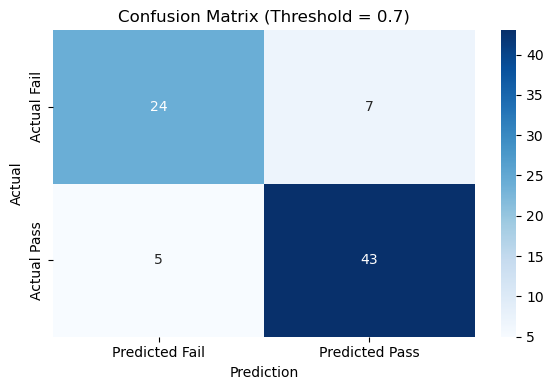


Classification Report:
              precision    recall  f1-score   support

        Fail       0.83      0.77      0.80        31
        Pass       0.86      0.90      0.88        48

    accuracy                           0.85        79
   macro avg       0.84      0.84      0.84        79
weighted avg       0.85      0.85      0.85        79



In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

#Change threshold for prediction to help with predicting Fails
y_proba = best_knn.predict_proba(X_test)[:, 1]
threshold = 0.7
y_pred_adjusted = (y_proba >= threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_adjusted)
labels = ['Fail', 'Pass']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Fail', 'Predicted Pass'],
            yticklabels=['Actual Fail', 'Actual Pass'])
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Threshold = 0.7)')
plt.tight_layout()
plt.show()

#Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted, target_names=labels))
